In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *

%matplotlib inline
%matplotlib ipympl

In [2]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [3]:
pd_data = pd.read_csv(SPECIFIED_CSV + "_urp_data.csv")
pd_data

,x_data
0,-361.650494
1,-349.496495
2,-342.204122
3,-332.964757
4,-334.219583
...,...
95,-293.890777
96,-281.031913
97,-291.070773
98,-297.938998


[[0.9974368]]
[[0.]]
[[0.]]
[[0.]]


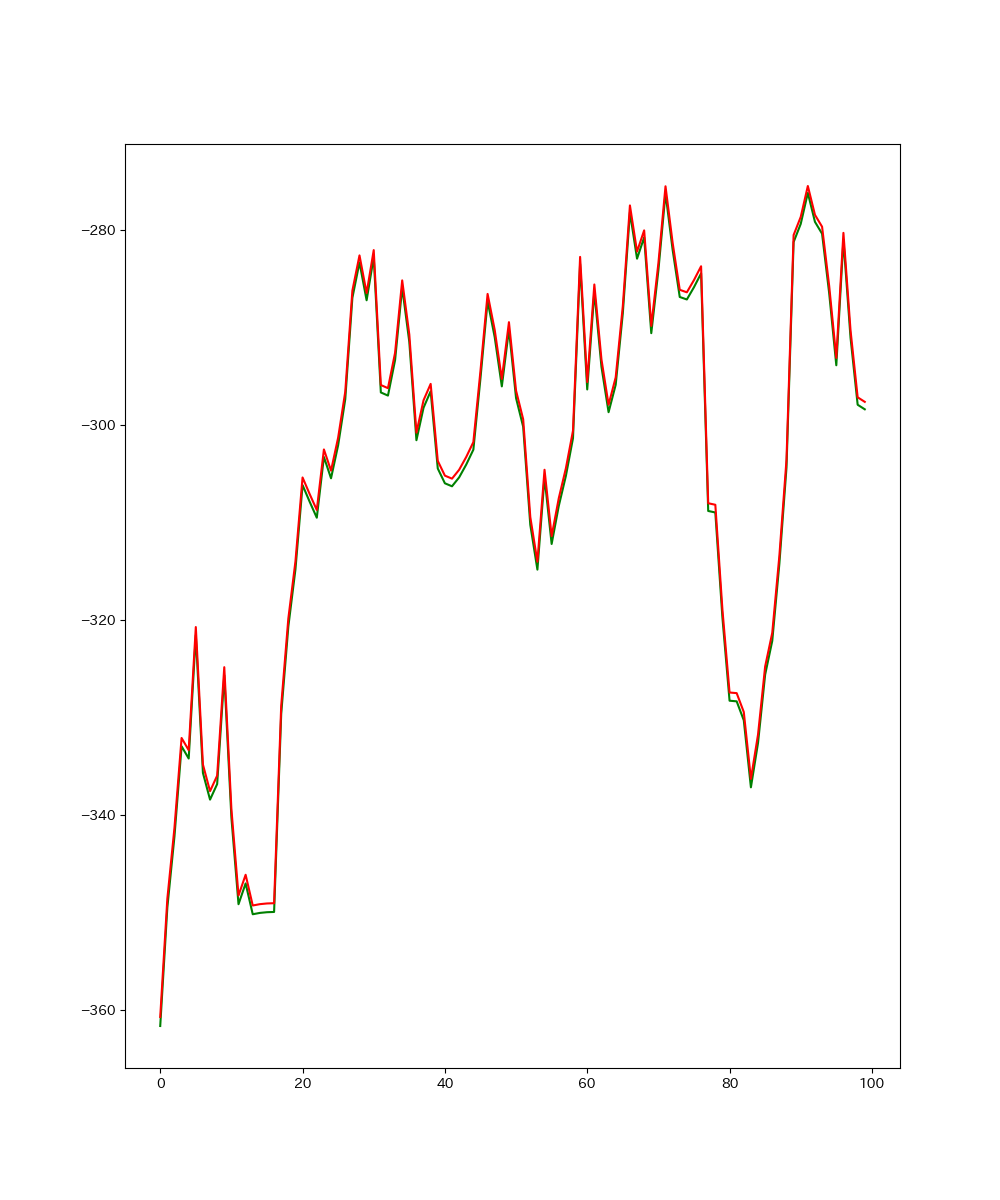

In [14]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&2次のトレンドあり
dfruler = Dickey_Fuller_Test(pd_data, regression="n")
dfruler.fit()
y_pred = dfruler.predict(pd_data, np.arange(len(pd_data)).reshape([len(pd_data), 1]))

plt.figure(figsize=(10, 12))
plt.plot(pd_data, "-", color="green")
plt.plot(y_pred,  "-", color="red")

print(dfruler.alpha)
print(dfruler.alpha0)
print(dfruler.trend_1st)
print(dfruler.trend_2nd)


In [15]:
res = dfruler.dfRuller()
print(dfruler.alpha)
print(dfruler.alpha0)
print(dfruler.trend_1st)
print(dfruler.trend_2nd)
print("t値：", res[0], "p値：", res[1])

[[0.9974368]]
[[0.]]
[[0.]]
[[0.]]
t値： -0.9913276564948721 p値： 0.29158821024384396


In [ ]:
print(np.hstack([dfruler.alpha, dfruler.alpha0]).ravel())